In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.models import ResNet18_Weights
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [3]:
weights = ResNet18_Weights.IMAGENET1K_V1
resnet18 = models.resnet18(weights=weights)

num_classes = len(datasets.ImageFolder(root='../../dataset/train').classes)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

In [4]:
resnet18 = resnet18.to(device)

In [5]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
train_dataset = datasets.ImageFolder(root='../../dataset/train', transform=transform)
test_dataset = datasets.ImageFolder(root='../../dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [7]:
memory_allocated = []
memory_reserved = []

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

start = torch.cuda.Event(enable_timing=True)
start.record()

num_epochs = 10
train_losses = []
for epoch in range(num_epochs):
    resnet18.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if torch.cuda.is_available():
            memory_allocated.append(torch.cuda.memory_allocated(device) / 1e6)  # Convert to MB
            memory_reserved.append(torch.cuda.memory_reserved(device) / 1e6)    # Convert to MB
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete.")

Epoch [1/10], Loss: 0.3589
Epoch [2/10], Loss: 0.1445
Epoch [3/10], Loss: 0.1055
Epoch [4/10], Loss: 0.0864
Epoch [5/10], Loss: 0.0817
Epoch [6/10], Loss: 0.0606
Epoch [7/10], Loss: 0.0593
Epoch [8/10], Loss: 0.0462
Epoch [9/10], Loss: 0.0559
Epoch [10/10], Loss: 0.0403
Training complete.


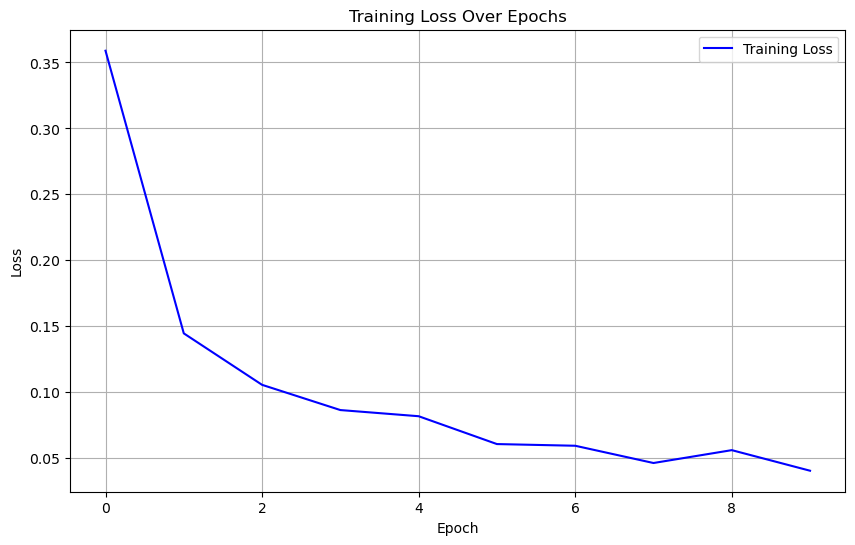

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [10]:
end = torch.cuda.Event(enable_timing=True)
end.record()

torch.cuda.synchronize()
print(f"Total Time (in mins) elapsed: {(start.elapsed_time(end) / 60000):.2f}")

Total Time (in mins) elapsed: 27.54


In [11]:
resnet18.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'ResNet Model Test Accuracy: {accuracy:.2f}%')

ResNet Model Test Accuracy: 96.33%


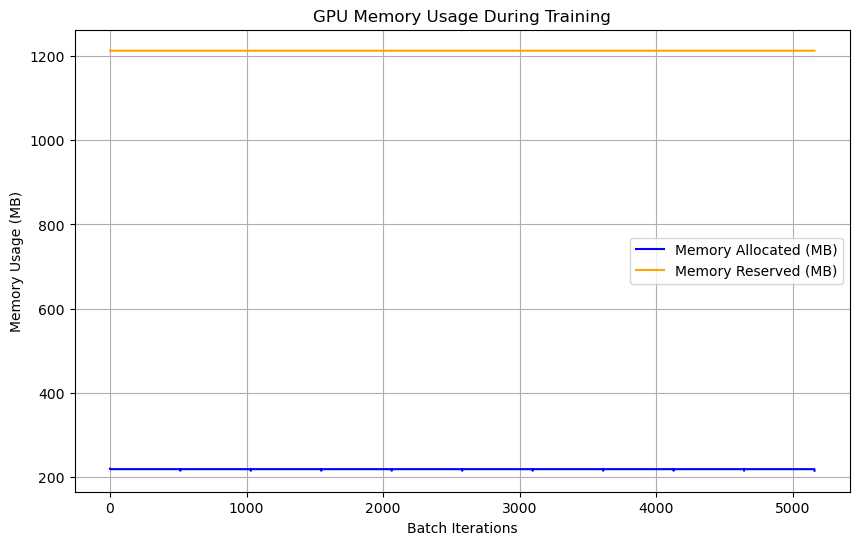

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(memory_allocated, label="Memory Allocated (MB)", color='blue')
plt.plot(memory_reserved, label="Memory Reserved (MB)", color='orange')
plt.xlabel("Batch Iterations")
plt.ylabel("Memory Usage (MB)")
plt.title("GPU Memory Usage During Training")
plt.legend()
plt.grid()
plt.show()